In [1]:
from cuml.ensemble import RandomForestClassifier
import cv2 
import os
import  numpy as np
from tqdm import tqdm 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import gc
import numpy as np

In [6]:
data_path="/kaggle/input/hath-food/food dataset/Images"

In [7]:
def get_histogram(img_path,bins=[8,8,8]):
    img=cv2.imread(img_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,[0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [8]:
def load_dataset(root_path, subset="train"):
    print(BINS)

    data = []
    labels = []
    
    path = os.path.join(root_path, subset)
    if not os.path.exists(path):
        print(f"error in finding {path}")
        return np.array([]), np.array([])

    print(f"loading {subset}...")
    
    classes = os.listdir(path)
    
    for class_name in classes:
        class_dir = os.path.join(path, class_name)
        if not os.path.isdir(class_dir):
            continue
            
      
        files = os.listdir(class_dir)
        for file in tqdm(files, desc=class_name, leave=False):
            image_path = os.path.join(class_dir, file)
            
            hist = get_histogram(image_path, BINS)
            
            if hist is not None:
                data.append(hist)
                labels.append(class_name)
                
    return np.array(data), np.array(labels)

In [9]:
BINS=[16,8,4]
BASE_PATH="/kaggle/input/hath-food/food dataset/Images"

In [10]:
X_train, y_train_text = load_dataset(BASE_PATH, "train")
X_test, y_test_text = load_dataset(BASE_PATH, "test")

[16, 8, 4]
loading train...


Nem chua:  20%|█▉        | 75/379 [00:00<00:03, 89.85it/s]   Corrupt JPEG data: 9 extraneous bytes before marker 0xe2


[16, 8, 4]
loading test...


In [11]:
le = LabelEncoder()
y_train = le.fit_transform(y_train_text)
y_test = le.transform(y_test_text) 

In [12]:
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [76]:
import optuna
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score

def objective(trial):
    # ----- Tham số tương đương param_grid của m -----
    n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 300, 500])
    max_depth = trial.suggest_categorical("max_depth", [10, 20, 30, 40])
    min_samples_split = trial.suggest_categorical("min_samples_split", [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 4])

    # ----- Build model (cuml) -----
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # ----- Train -----
    clf.fit(X_train, y_train)     # nhớ X, y là GPU array (cuDF hoặc cupy hoặc cuml array)

    # ----- Predict -----
    y_pred = clf.predict(X_test)

    # ----- Accuracy cuML -----
    acc = accuracy_score(y_test, y_pred)

    return float(acc)   # Optuna cần float python

# ----- Run Optuna -----
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best params:", study.best_params)
print("Best score:", study.best_value)


[I 2025-12-10 13:19:15,142] A new study created in memory with name: no-name-3b0dd35a-bb98-4635-a667-27f1c48c4d17
[I 2025-12-10 13:19:19,387] Trial 0 finished with value: 0.2750000059604645 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.2750000059604645.
[I 2025-12-10 13:19:31,126] Trial 1 finished with value: 0.3351190388202667 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.3351190388202667.
[I 2025-12-10 13:19:42,045] Trial 2 finished with value: 0.33273810148239136 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.3351190388202667.
[I 2025-12-10 13:20:02,751] Trial 3 finished with value: 0.3331349194049835 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with valu

Best params: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 4}
Best score: 0.3351190388202667


In [45]:
import optuna
import gc
import cupy as cp  # Cần thư viện này để thao tác bộ nhớ GPU
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score

# Đảm bảo dữ liệu đầu vào là float32 để tiết kiệm 50% VRAM
# (Chạy dòng này ở cell trước hoặc bỏ comment nếu X_train chưa phải là float32)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

def objective(trial):
    try:
        # ----- Tham số -----
        n_estimators = trial.suggest_categorical("n_estimators", [100, 200, 300]) # Bỏ 500 nếu RAM yếu
        min_samples_split = trial.suggest_categorical("min_samples_split", [2, 5, 10])
        min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 4])
        
        # QUAN TRỌNG: Thêm max_depth. Nếu không có, cây mọc vô tận -> tràn RAM ngay lập tức.
        max_depth = trial.suggest_int("max_depth", 10, 40)

        # ----- Build model (cuml) -----
        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_depth=max_depth,       
        )

        # ----- Train -----
        clf.fit(X_train, y_train)

        # ----- Predict -----
        # Nếu X_test quá lớn, predict có thể gây tràn RAM.
        # cuml RF thường predict nhanh, nhưng nếu crash ở đây thì cần chia batch.
        y_pred = clf.predict(X_test)

        # ----- Accuracy cuML -----
        acc = accuracy_score(y_test, y_pred)
        
        # Lưu lại giá trị cần return
        result = float(acc)

    except Exception as e:
        # Nếu bị lỗi (VD: OOM), return giá trị thấp để Optuna tránh params này
        print(f"Trial failed: {e}")
        result = 0.0

    finally:
        # ----- QUAN TRỌNG: Dọn dẹp bộ nhớ sau mỗi trial -----
        # Xóa các biến tham chiếu đến GPU object
        if 'clf' in locals(): del clf
        if 'y_pred' in locals(): del y_pred
        
        # Gọi Garbage Collector của Python
        gc.collect()
        
        # Gọi hàm dọn dẹp bộ nhớ cache của CuPy/RMM
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()

    return result

# ----- Run Optuna -----
# Thêm gc_after_trial=True để Optuna chủ động dọn dẹp
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, gc_after_trial=True)

print("Best params:", study.best_params)
print("Best score:", study.best_value)

[I 2025-12-10 14:46:16,060] A new study created in memory with name: no-name-fa18b2f2-85e6-460e-a637-ab8a3c0f4cc7
[I 2025-12-10 14:46:21,050] Trial 0 finished with value: 0.32797619700431824 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 33}. Best is trial 0 with value: 0.32797619700431824.
[I 2025-12-10 14:46:22,813] Trial 1 finished with value: 0.30694442987442017 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 34}. Best is trial 0 with value: 0.32797619700431824.
[I 2025-12-10 14:46:24,704] Trial 2 finished with value: 0.3095238208770752 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 33}. Best is trial 0 with value: 0.32797619700431824.
[I 2025-12-10 14:46:32,432] Trial 3 finished with value: 0.32599207758903503 and parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 23}. Best is trial 0 w

Best params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 25}
Best score: 0.3325396776199341


In [42]:
import optuna
import gc
import cupy as cp  # Cần thư viện này để thao tác bộ nhớ GPU
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score

# Đảm bảo dữ liệu đầu vào là float32 để tiết kiệm 50% VRAM
# (Chạy dòng này ở cell trước hoặc bỏ comment nếu X_train chưa phải là float32)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

def objective(trial):
    try:
        # ----- Tham số -----
        n_estimators = trial.suggest_categorical("n_estimators", [500]) # Bỏ 500 nếu RAM yếu
        min_samples_split = trial.suggest_categorical("min_samples_split", [2, 5, 10])
        min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 4])
        
        # QUAN TRỌNG: Thêm max_depth. Nếu không có, cây mọc vô tận -> tràn RAM ngay lập tức.
        max_depth = trial.suggest_int("max_depth", 10, 40)

        # ----- Build model (cuml) -----
        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_depth=max_depth,       # Giới hạn độ sâu
        )

        # ----- Train -----
        clf.fit(X_train, y_train)

        # ----- Predict -----
        # Nếu X_test quá lớn, predict có thể gây tràn RAM.
        # cuml RF thường predict nhanh, nhưng nếu crash ở đây thì cần chia batch.
        y_pred = clf.predict(X_test)

        # ----- Accuracy cuML -----
        acc = accuracy_score(y_test, y_pred)
        
        # Lưu lại giá trị cần return
        result = float(acc)

    except Exception as e:
        # Nếu bị lỗi (VD: OOM), return giá trị thấp để Optuna tránh params này
        print(f"Trial failed: {e}")
        result = 0.0

    finally:
        # ----- QUAN TRỌNG: Dọn dẹp bộ nhớ sau mỗi trial -----
        # Xóa các biến tham chiếu đến GPU object
        if 'clf' in locals(): del clf
        if 'y_pred' in locals(): del y_pred
        
        # Gọi Garbage Collector của Python
        gc.collect()
        
        # Gọi hàm dọn dẹp bộ nhớ cache của CuPy/RMM
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()

    return result

# ----- Run Optuna -----
# Thêm gc_after_trial=True để Optuna chủ động dọn dẹp
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, gc_after_trial=True)

print("Best params:", study.best_params)
print("Best score:", study.best_value)

[I 2025-12-10 14:34:44,896] A new study created in memory with name: no-name-2e39d3c6-3f01-4f71-93f0-1f6e50e8886c
[I 2025-12-10 14:34:56,923] Trial 0 finished with value: 0.3313491940498352 and parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 27}. Best is trial 0 with value: 0.3313491940498352.
[I 2025-12-10 14:35:09,366] Trial 1 finished with value: 0.3303571343421936 and parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 39}. Best is trial 0 with value: 0.3313491940498352.
[I 2025-12-10 14:35:17,530] Trial 2 finished with value: 0.335317462682724 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 36}. Best is trial 2 with value: 0.335317462682724.
[I 2025-12-10 14:35:24,413] Trial 3 finished with value: 0.30892857909202576 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 13}. Best is trial 2 with value

Best params: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 27}
Best score: 0.3392857015132904


In [58]:
import cuml
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# 1. Tham số
param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# 2. Khởi tạo Model & GridSearch
rf = RandomForestClassifier()

# cv=3: Nó sẽ tự chia X_train làm 3 phần để kiểm tra chéo (Cross-Validation)
# verbose=10: Để nó in log ra cho bạn đỡ sốt ruột (thay vì thanh loading)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,            
    scoring='accuracy',
    verbose=10       
)

print("Đang chạy Grid Search bằng cuML...")

# 3. Fit (Chỉ đưa X_train, y_train vào, nó tự lo phần validation nội bộ)
grid_search.fit(X_train, y_train)

# 4. Kết quả
print("\n" + "="*30)
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# 5. Test trên tập X_test của bạn
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Do cuml predict có thể trả về dữ liệu GPU, ta chuyển về CPU để tính accuracy cuối cùng
if hasattr(y_pred, 'to_numpy'):
    y_pred = y_pred.to_numpy()
elif hasattr(y_pred, 'get'):
    y_pred = y_pred.get()

print("Final Accuracy on Test Set:", accuracy_score(y_test, y_pred))

Đang chạy Grid Search bằng cuML...
Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3; 1/144] START max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/3; 1/144] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.272 total time=   0.6s
[CV 2/3; 1/144] START max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/3; 1/144] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.258 total time=   0.4s
[CV 3/3; 1/144] START max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/3; 1/144] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.261 total time=   0.4s
[CV 1/3; 2/144] START max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/3; 2/144] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.277 total time=   0.8s
[CV 2/3; 2/144] START max_

In [59]:
classifier = RandomForestClassifier(n_estimators=500,min_samples_split=2,min_samples_leaf=2,max_depth=40)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [60]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 33.83%


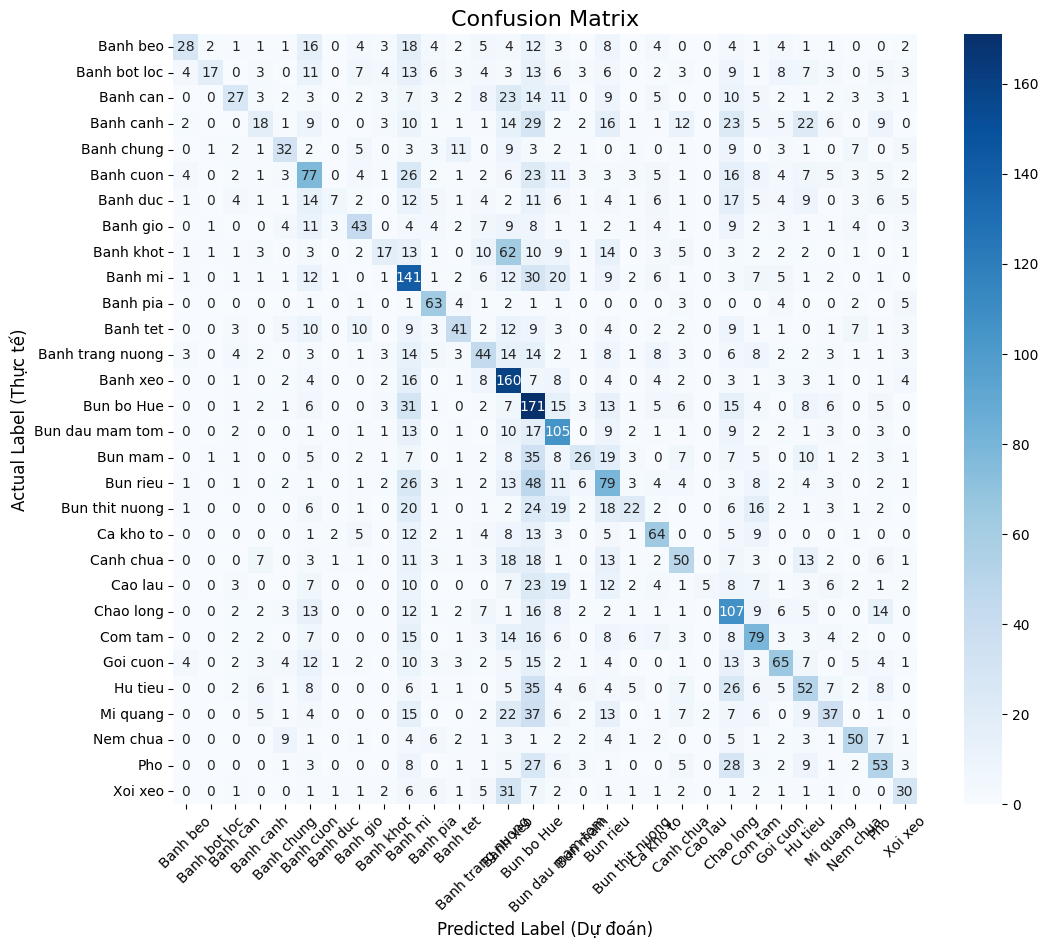

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# --- 1. Tạo mapping từ Số sang Chữ ---
# Dùng y_train và y_train_text để tạo từ điển. 
# Ví dụ nó sẽ tạo ra: {0: 'Apple', 1: 'Banana', 2: 'Orange'...}
label_map = dict(zip(y_train, y_train_text))

# --- 2. Tạo y_pred_text từ y_pred ---
# Duyệt qua từng số trong y_pred và đổi nó thành chữ dựa vào từ điển trên
y_pred_text = [label_map[label] for label in y_pred]

# --- 3. Vẽ Confusion Matrix ---

# Lấy danh sách các tên class duy nhất để làm trục
unique_labels = np.unique(y_test_text)

# Tạo ma trận
cm = confusion_matrix(y_test_text, y_pred_text, labels=unique_labels)

# Vẽ
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, yticklabels=unique_labels)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label (Dự đoán)', fontsize=12)
plt.ylabel('Actual Label (Thực tế)', fontsize=12)
plt.xticks(rotation=45)
plt.show()